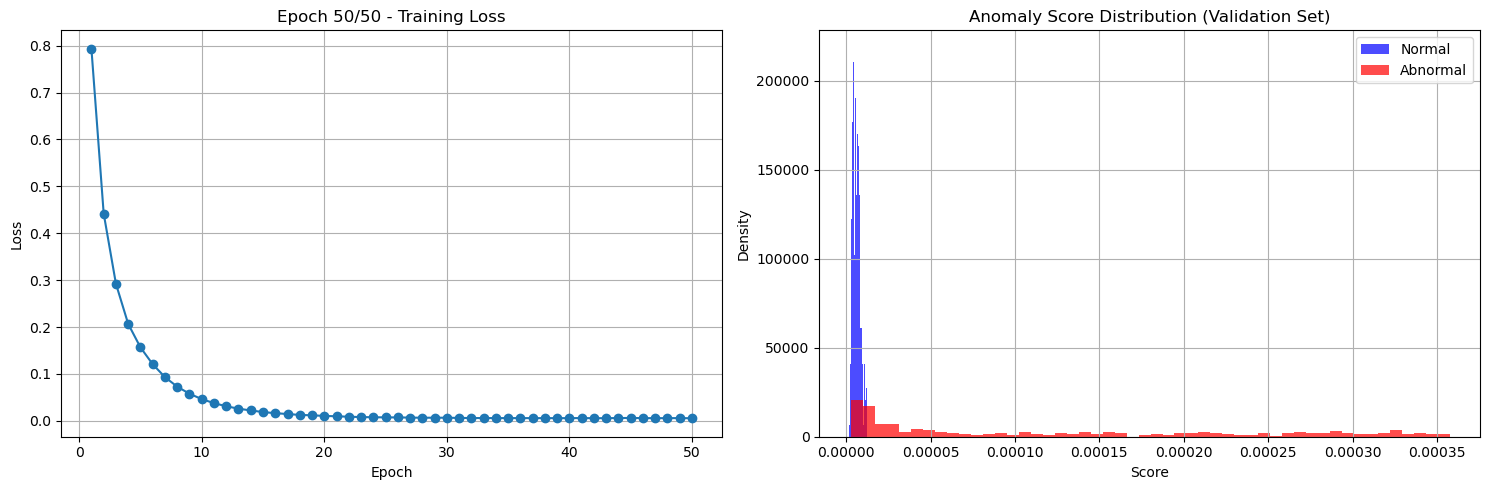

--- Training Finished ---

--- Predicting on Test Data ---


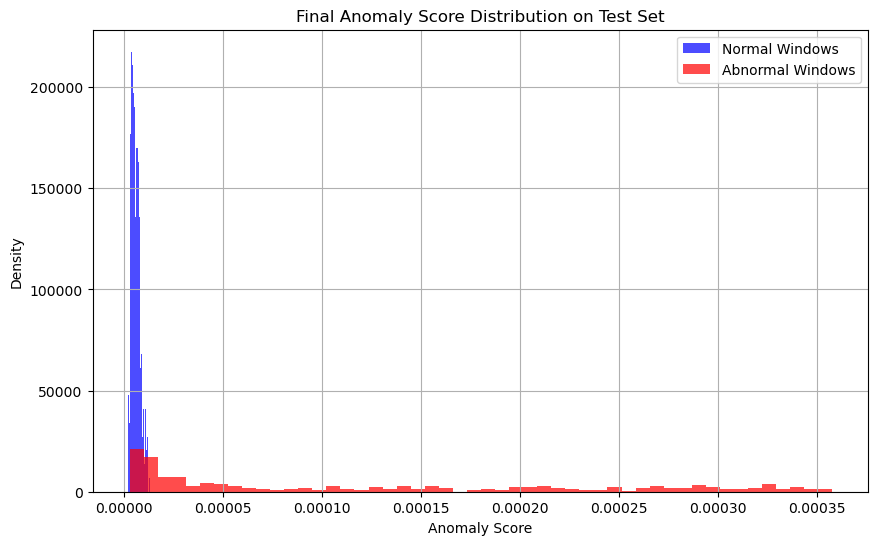

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 忽略 Matplotlib 的使用者警告
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

class THOC(nn.Module):
    """
    Temporal Hierarchical One-Class (THOC) Network 的 PyTorch 實現。
    嚴格遵循論文 "Timeseries Anomaly Detection using Temporal Hierarchical One-Class Network" (NeurIPS 2020)。
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=3, num_centers_per_layer=[5, 3, 1],
                 base_dilation=2, temperature=0.1, device='cpu'):
        """
        初始化 THOC 模型。
        
        Args:
            input_dim (int): 輸入時間序列的特徵維度。
            hidden_dim (int): RNN 和內部特徵的隱藏維度。
            num_layers (int): Dilated RNN 的層數 (L)。
            num_centers_per_layer (list): 每層的聚類核心數量 (K^l)。
            base_dilation (int): 擴張率的基數 (M)。
            temperature (float): Softmax 溫度參數 (τ)。
            device (str): 'cuda' 或 'cpu'。
        """
        super(THOC, self).__init__()
        
        # 參數設定
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.L = num_layers
        self.K = num_centers_per_layer # [K^1, K^2, ..., K^L]
        self.tau = temperature
        self.device = device

        # --- Section 3.1.1: Multiscale Temporal Features (Dilated RNN) ---
        # 建立 L 層的 Dilated RNN，這裡使用 GRU Cell
        self.dilated_rnn_cells = nn.ModuleList([
            nn.GRUCell(input_dim if l == 0 else hidden_dim, hidden_dim) for l in range(self.L)
        ])
        
        # 計算每層的 skip lengths (s^(l))
        # s^(l) = M_0 * M^(l-1), 論文中 M_0=1
        self.skip_lengths = [base_dilation ** (l) for l in range(self.L)]

        # --- Section 3.1.2: Fusing the Multiscale Features ---
        # 聚類核心 (c_j^l)，設為可學習的參數
        self.cluster_centers = nn.ParameterList([
            nn.Parameter(torch.randn(self.K[l], hidden_dim)) for l in range(self.L)
        ])
        # 正規化核心以提高穩定性
        with torch.no_grad():
            for l in range(self.L):
                self.cluster_centers[l].data = F.normalize(self.cluster_centers[l].data, dim=1)

        # Update step (Eq. 7) 中的線性轉換層 (W^l, b^l)
        self.update_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for l in range(self.L)
        ])
        
        # Fusion step (Eq. 8) 中的 MLP (F_mlp)
        # 輸入是 [f_hat; f], 維度為 2 * hidden_dim
        self.fusion_mlps = nn.ModuleList([
            nn.Linear(2 * hidden_dim, hidden_dim) for l in range(self.L - 1)
        ])

        # --- Section 3.2: Temporal Self-Supervision (TSS) ---
        # 用於 L_TSS 的預測頭 (W_pred^l)
        self.tss_predictors = nn.ModuleList([
            nn.Linear(hidden_dim, input_dim) for l in range(self.L)
        ])

    def forward(self, X):
        """
        模型的前向傳播過程。
        
        Args:
            X (Tensor): 輸入的時間序列數據，形狀為 (batch_size, seq_len, input_dim)。
            
        Returns:
            dict: 包含計算損失所需的所有中間輸出的字典。
        """
        batch_size, seq_len, _ = X.shape
        
        # 1. Dilated RNN Pass (Section 3.1.1)
        # 儲存所有時間步的隱藏狀態
        f = [[torch.zeros(batch_size, self.hidden_dim).to(self.device) for _ in range(seq_len)] for _ in range(self.L)]
        
        for t in range(seq_len):
            for l in range(self.L):
                # RNN 輸入
                rnn_input = X[:, t, :] if l == 0 else f[l-1][t]
                
                # 考慮 dilation 的前一個隱藏狀態
                prev_h_idx = t - self.skip_lengths[l]
                prev_h = f[l][prev_h_idx] if prev_h_idx >= 0 else torch.zeros_like(f[l][0])
                
                f[l][t] = self.dilated_rnn_cells[l](rnn_input, prev_h)

        # 我們只關心最後一個時間步 t = seq_len-1 的特徵，用於異常檢測
        # f_t^l for t = seq_len - 1
        last_f = [f_l[-1] for f_l in f]

        # 2. Hierarchical Clustering & Fusion (Section 3.1.2)
        f_bar = {}
        R = {}
        
        # 初始化最底層輸入 (l=0)
        # Eq. 8: if l=0, f_bar^0 = f^1
        f_bar[0] = last_f[0].unsqueeze(1) # Shape: (batch, 1, hidden_dim)

        for l in range(self.L):
            # 當前層的輸入
            input_features = f_bar[l] # Shape: (batch, K^(l-1), hidden_dim)
            
            # --- Assignment Step (Eq. 5) ---
            # 計算輸入特徵與該層核心的餘弦相似度
            # input_features: (batch, K^(l-1), dim) -> (batch, K^(l-1), 1, dim)
            # centers: (K^l, dim) -> (1, 1, K^l, dim)
            # scores: (batch, K^(l-1), K^l)
            normalized_centers = F.normalize(self.cluster_centers[l], dim=1)
            scores = F.cosine_similarity(input_features.unsqueeze(2), normalized_centers.unsqueeze(0).unsqueeze(0), dim=-1)
            
            # P_{t, i->j}^l: (batch, K^(l-1), K^l)
            P = F.softmax(scores / self.tau, dim=-1)
            
            # --- R_t,j^l (Responsibility) Calculation (Eq. 10) ---
            if l == 0:
                # R_t,j^1 = P_{t, 1->j}^1
                # P shape is (batch, 1, K^1), so squeeze dim 1
                R_tilde = P.squeeze(1) # Shape: (batch, K^1)
            else:
                # R_tilde_j^l = sum_i(P_{i->j}^l * R_i^(l-1))
                # P: (batch, K^(l-1), K^l), R[l-1]: (batch, K^(l-1)) -> (batch, K^(l-1), 1)
                # R_tilde: (batch, K^l)
                R_tilde = torch.sum(P * R[l-1].unsqueeze(2), dim=1)
            
            R[l] = F.softmax(R_tilde, dim=-1) # Shape: (batch, K^l)
            
            # --- Update Step (Eq. 7) ---
            # f_hat_j^l = sum_i(P_{i->j}^l * ReLU(W^l * f_bar_i^(l-1) + b^l))
            # transformed_features: (batch, K^(l-1), hidden_dim)
            transformed_features = F.relu(self.update_layers[l](input_features))
            # f_hat: (batch, K^l, hidden_dim)
            f_hat = torch.bmm(P.transpose(1, 2), transformed_features)
            
            # --- Fusion for next layer's input (Eq. 8) ---
            if l < self.L - 1:
                # Concatenate f_hat with f^(l+1) from dilated RNN
                rnn_feature_l_plus_1 = last_f[l+1].unsqueeze(1).expand(-1, self.K[l], -1)
                concat_features = torch.cat([f_hat, rnn_feature_l_plus_1], dim=-1)
                
                # Pass through MLP
                f_bar[l+1] = self.fusion_mlps[l](concat_features)
            else:
                # 最後一層的輸出就是 f_hat
                f_bar[l+1] = f_hat

        # 3. Anomaly Score Calculation (Eq. 173)
        # f_L_final: (batch_size, K^L, hidden_dim)
        f_L_final = f_bar[self.L]
        centers_L = F.normalize(self.cluster_centers[self.L-1], dim=1) # Shape: (K^L, hidden_dim)
        
        # Cosine distance: 1 - cosine_similarity
        # dists shape: (batch, K^L)
        dists = 1 - F.cosine_similarity(f_L_final, centers_L.unsqueeze(0), dim=-1)
        
        # R_L: (batch, K^L)
        R_L = R[self.L-1]
        
        # anomaly_score: (batch)
        anomaly_scores = torch.sum(R_L * dists, dim=1)
        
        # 4. TSS Prediction (for L_TSS loss)
        # (Eq. 12)
        tss_predictions = []
        tss_targets = []
        for l in range(self.L):
            skip = self.skip_lengths[l]
            if seq_len > skip:
                # Predict X_t from f_{t-s^(l)}^l
                # Here, we predict last X from f at (last - skip)
                pred_input_state = f[l][-skip-1] # f_t-s^(l)
                tss_predictions.append(self.tss_predictors[l](pred_input_state))
                tss_targets.append(X[:, -1, :]) # X_t
                
        return {
            "anomaly_scores": anomaly_scores, # L_THOC uses this
            "cluster_centers": self.cluster_centers, # L_orth uses this
            "tss_predictions": tss_predictions, # L_TSS uses this
            "tss_targets": tss_targets,
            "R_L": R_L,
            "dists": dists,
        }

class Agent:
    def __init__(self, input_dim, window_size, hidden_dim=64, num_layers=3, 
                 num_centers_per_layer=[5, 3, 1], base_dilation=2, temperature=0.1, 
                 lr=1e-4, lambda_orth=0.1, lambda_tss=1.0, device=None):
        
        # 內建模型和訓練的設定
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Agent is using device: {self.device}")
        
        self.model = THOC(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_centers_per_layer=num_centers_per_layer,
            base_dilation=base_dilation,
            temperature=temperature,
            device=self.device
        ).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.lambda_orth = lambda_orth
        self.lambda_tss = lambda_tss
        self.L = num_layers
        self.window_size = window_size

    def _calculate_loss(self, outputs):
        # 1. L_THOC (Eq. 9, but simplified as anomaly_score in forward)
        # The objective is to minimize the anomaly score for normal data
        loss_thoc = torch.mean(outputs["anomaly_scores"])
        
        # 2. L_orth (Eq. 11)
        loss_orth = 0.0
        for l in range(self.L):
            centers = F.normalize(outputs["cluster_centers"][l], dim=1)
            
            # --- START OF FIX ---
            # 原本的錯誤: torch.matmul(centers.t(), centers) 的結果是 (d, d)
            # 正確的計算: torch.matmul(centers, centers.t()) 的結果是 (K^l, K^l)
            # 這計算了 K^l 個核心向量兩兩之間的內積
            C_C_T = torch.matmul(centers, centers.t())
            # --- END OF FIX ---

            identity = torch.eye(centers.shape[0]).to(self.device)
            # 比較 (K^l, K^l) 的矩陣與單位矩陣
            loss_orth += torch.norm(C_C_T - identity, p='fro')**2
            
        loss_orth /= self.L
        
        # 3. L_TSS (Eq. 12)
        loss_tss = 0.0
        if len(outputs["tss_predictions"]) > 0:
            for pred, target in zip(outputs["tss_predictions"], outputs["tss_targets"]):
                loss_tss += F.mse_loss(pred, target)
            loss_tss /= len(outputs["tss_predictions"])
        
        # L_total (Eq. 13)
        total_loss = loss_thoc + self.lambda_orth * loss_orth + self.lambda_tss * loss_tss
        
        return total_loss, loss_thoc, loss_orth, loss_tss

    def train(self, train_loader, epochs, val_loader=None):
        self.model.train()
        epoch_losses = []
        
        for epoch in range(epochs):
            batch_losses = []
            for X_batch in train_loader:
                X_batch = X_batch[0].to(self.device)
                
                self.optimizer.zero_grad()
                
                outputs = self.model(X_batch)
                loss, _, _, _ = self._calculate_loss(outputs)
                
                loss.backward()
                self.optimizer.step()
                
                batch_losses.append(loss.item())
            
            epoch_loss = np.mean(batch_losses)
            epoch_losses.append(epoch_loss)
            
            if (epoch + 1) % 10 == 0:
                clear_output(wait=True)
                
                fig, axes = plt.subplots(1, 2, figsize=(15, 5))
                
                # 1. 繪製 Learning Curve
                axes[0].plot(range(1, epoch + 2), epoch_losses, marker='o')
                axes[0].set_title(f"Epoch {epoch+1}/{epochs} - Training Loss")
                axes[0].set_xlabel("Epoch")
                axes[0].set_ylabel("Loss")
                axes[0].grid(True)
                
                # 2. 繪製異常分數分佈
                if val_loader:
                    scores_normal = []
                    scores_abnormal = []
                    self.model.eval()
                    with torch.no_grad():
                        for X_val, y_val in val_loader:
                            X_val = X_val.to(self.device)
                            outputs = self.model(X_val)
                            scores = outputs["anomaly_scores"].cpu().numpy()
                            
                            for i in range(len(scores)):
                                if y_val[i] == 0: # Normal
                                    scores_normal.append(scores[i])
                                else: # Abnormal
                                    scores_abnormal.append(scores[i])
                    self.model.train() # 切回訓練模式

                    axes[1].hist(scores_normal, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
                    if scores_abnormal:
                      axes[1].hist(scores_abnormal, bins=50, alpha=0.7, label='Abnormal', color='red', density=True)
                    axes[1].set_title("Anomaly Score Distribution (Validation Set)")
                    axes[1].set_xlabel("Score")
                    axes[1].set_ylabel("Density")
                    axes[1].legend()
                    axes[1].grid(True)

                plt.tight_layout()
                plt.show()

    def predict(self, dataloader):
        self.model.eval()
        all_scores = []
        with torch.no_grad():
            for X_batch in dataloader:
                X_batch = X_batch[0].to(self.device)
                outputs = self.model(X_batch)
                scores = outputs["anomaly_scores"].cpu().numpy()
                all_scores.extend(scores)
        return np.array(all_scores)

# 主程式
if __name__ == '__main__':
    
    # 1. 產生合成時間序列數據
    np.random.seed(42)
    T = 1000
    time = np.arange(0, T, 1)
    
    # 正常數據：sin波 + 小隨機擾動
    normal_series = np.sin(0.1 * time) + np.random.normal(0, 0.1, T)
    
    # 異常數據
    abnormal_series_1 = normal_series.copy()
    abnormal_series_1[200:250] += np.random.normal(0, 0.5, 50) # 注入更大的噪音

    abnormal_series_2 = normal_series.copy()
    abnormal_series_2[500:550] = np.random.normal(0, 1.0, 50) # 整段都是高斯噪音

    abnormal_series_3 = normal_series.copy()
    abnormal_series_3[700:750] = np.sin(0.5 * time[700:750]) * 1.5 # 直接產生形變

    # 合併成測試數據
    test_series = normal_series.copy()
    test_series[200:250] = abnormal_series_1[200:250]
    test_series[500:550] = abnormal_series_2[500:550]
    test_series[700:750] = abnormal_series_3[700:750]

    # 產生標籤
    labels = np.zeros(T)
    labels[200:250] = 1
    labels[500:550] = 1
    labels[700:750] = 1
    
    # 視覺化數據
    plt.figure(figsize=(15, 5))
    plt.plot(time, test_series, label='Time Series')
    plt.fill_between(time, -2, 2, where=labels==1, color='red', alpha=0.3, label='Anomalies')
    plt.title("Synthetic Time Series Data with Anomalies")
    plt.legend()
    plt.show()

    # 2. Sliding Window 切分程式碼
    def create_windows(data, labels, window_size):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i+window_size])
            # 如果窗口內有任何異常點，則標記為異常
            y.append(1 if np.any(labels[i:i+window_size] == 1) else 0)
        return np.array(X), np.array(y)

    WINDOW_SIZE = 50
    
    # 訓練數據（只有正常部分）
    train_data, _ = create_windows(normal_series, np.zeros_like(normal_series), WINDOW_SIZE)
    train_data = torch.from_numpy(train_data).float().unsqueeze(-1) # 增加特徵維度
    train_dataset = TensorDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # 測試數據（包含正常與異常）
    test_data, test_labels = create_windows(test_series, labels, WINDOW_SIZE)
    test_data = torch.from_numpy(test_data).float().unsqueeze(-1)
    test_labels = torch.from_numpy(test_labels).long()
    test_dataset = TensorDataset(test_data, test_labels)
    test_loader_for_plot = DataLoader(test_dataset, batch_size=64, shuffle=False)
    test_loader_for_predict = DataLoader(TensorDataset(test_data), batch_size=64, shuffle=False)

    # 3. 建構 Agent 並開始訓練
    print("\n--- Starting Training ---")
    # 為了演示，我們使用較少的 epochs
    # 在真實場景中，可能需要更多的 epochs 和超參數調整
    agent = Agent(input_dim=1, window_size=WINDOW_SIZE, lr=1e-3, lambda_orth=0.05, lambda_tss=0.5)
    agent.train(train_loader, epochs=50, val_loader=test_loader_for_plot)
    print("--- Training Finished ---\n")
    
    # 4. 預測並畫出最終的分數分佈圖
    print("--- Predicting on Test Data ---")
    anomaly_scores = agent.predict(test_loader_for_predict)
    
    normal_scores = anomaly_scores[test_labels == 0]
    abnormal_scores = anomaly_scores[test_labels == 1]
    
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal Windows', color='blue', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal Windows', color='red', density=True)
    plt.title("Final Anomaly Score Distribution on Test Set")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

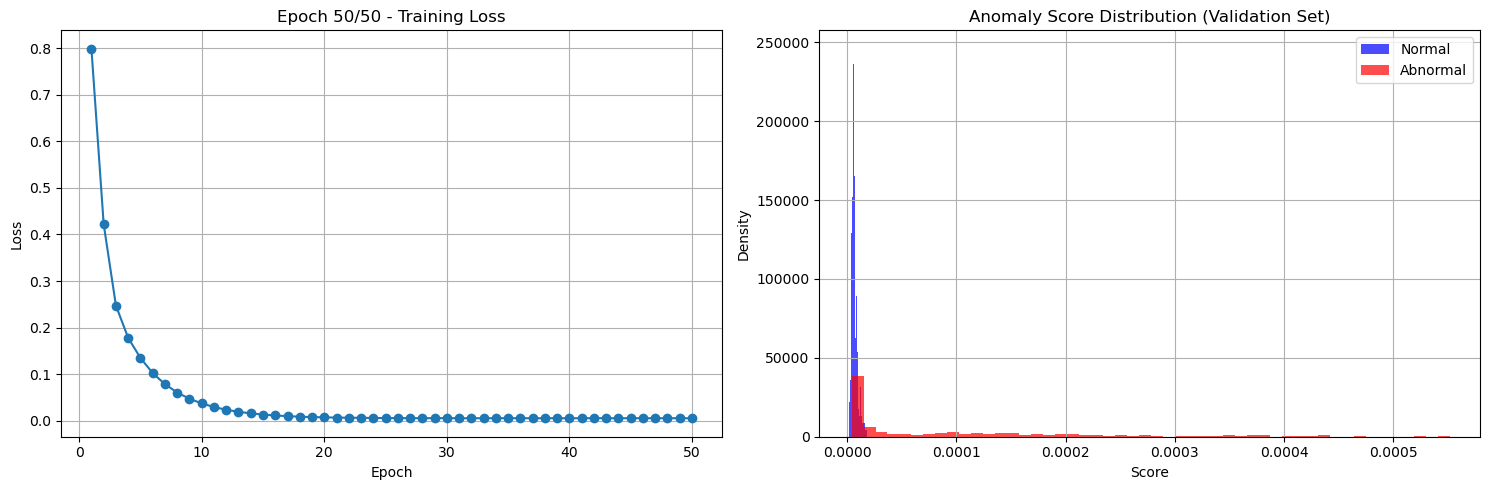

--- Training Finished ---

--- Predicting on Test Data ---


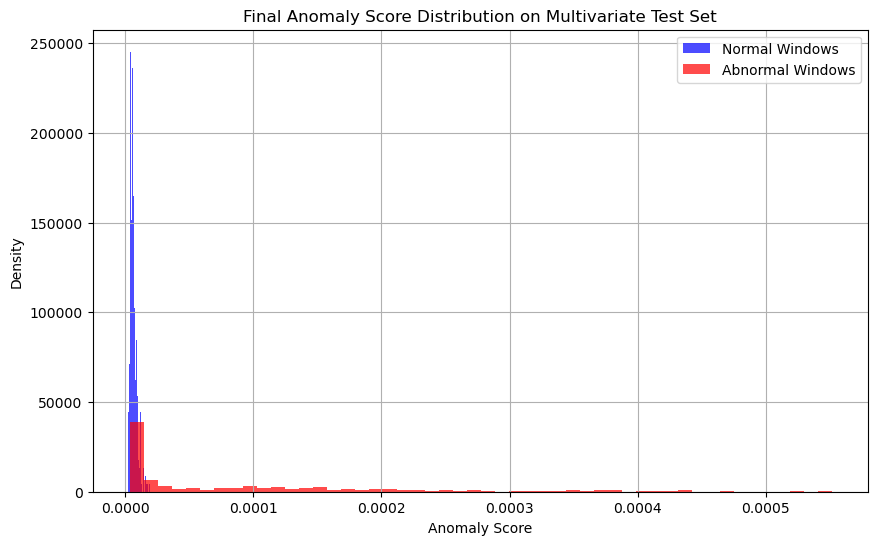

In [3]:
# 主程式 (多變量版本)
if __name__ == '__main__':
    
    # 1. 產生合成的多變量時間序列數據
    np.random.seed(42)
    T = 1000
    time = np.arange(0, T, 1)
    N_FEATURES = 2 # CHANGED: 設定特徵數量為 2

    # 正常數據：[sin波, cos波] + 小隨機擾動
    # Shape: (1000, 2)
    normal_series = np.zeros((T, N_FEATURES))
    normal_series[:, 0] = np.sin(0.1 * time) + np.random.normal(0, 0.1, T)
    normal_series[:, 1] = np.cos(0.1 * time) + np.random.normal(0, 0.1, T)
    
    # 建立測試數據，並在其中一個特徵上注入異常
    test_series = normal_series.copy()
    
    # 異常1: 在第一個特徵注入更大的噪音
    test_series[200:250, 0] += np.random.normal(0, 0.5, 50) 
    
    # 異常2: 在第二個特徵注入高斯噪音
    test_series[500:550, 1] = np.random.normal(0, 1.0, 50)
    
    # 異常3: 在第一個特徵產生形變
    test_series[700:750, 0] = np.sin(0.5 * time[700:750]) * 1.5

    # 產生標籤 (只要任一特徵在該時間點異常，就標記為 1)
    labels = np.zeros(T)
    labels[200:250] = 1
    labels[500:550] = 1
    labels[700:750] = 1
    
    # 視覺化數據
    plt.figure(figsize=(15, 6))
    plt.plot(time, test_series[:, 0], label='Feature 1')
    plt.plot(time, test_series[:, 1], label='Feature 2')
    plt.fill_between(time, -2.5, 2.5, where=labels==1, color='red', alpha=0.3, label='Anomalies')
    plt.title("Synthetic Multivariate Time Series Data with Anomalies")
    plt.legend()
    plt.show()

    # 2. Sliding Window 切分程式碼 (此函式無需改變)
    def create_windows(data, labels, window_size):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i+window_size])
            # 如果窗口內有任何異常點，則標記為異常
            y.append(1 if np.any(labels[i:i+window_size] == 1) else 0)
        return np.array(X), np.array(y)

    WINDOW_SIZE = 50
    
    # 訓練數據（只有正常部分）
    train_data, _ = create_windows(normal_series, np.zeros_like(normal_series[:, 0]), WINDOW_SIZE)
    # CHANGED: 數據已有特徵維度，不再需要 .unsqueeze(-1)
    train_data = torch.from_numpy(train_data).float()
    train_dataset = TensorDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # 測試數據（包含正常與異常）
    test_data, test_labels = create_windows(test_series, labels, WINDOW_SIZE)
    # CHANGED: 數據已有特徵維度，不再需要 .unsqueeze(-1)
    test_data = torch.from_numpy(test_data).float()
    test_labels = torch.from_numpy(test_labels).long()
    test_dataset = TensorDataset(test_data, test_labels)
    test_loader_for_plot = DataLoader(test_dataset, batch_size=64, shuffle=False)
    test_loader_for_predict = DataLoader(TensorDataset(test_data), batch_size=64, shuffle=False)

    # 3. 建構 Agent 並開始訓練
    print("\n--- Starting Training for Multivariate Data---")
    # CHANGED: 將 input_dim 設為我們的特徵數量
    agent = Agent(input_dim=N_FEATURES, window_size=WINDOW_SIZE, lr=1e-3, lambda_orth=0.05, lambda_tss=0.5)
    
    # 為了演示，我們使用較少的 epochs
    agent.train(train_loader, epochs=50, val_loader=test_loader_for_plot)
    print("--- Training Finished ---\n")
    
    # 4. 預測並畫出最終的分數分佈圖
    print("--- Predicting on Test Data ---")
    anomaly_scores = agent.predict(test_loader_for_predict)
    
    normal_scores = anomaly_scores[test_labels == 0]
    abnormal_scores = anomaly_scores[test_labels == 1]
    
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal Windows', color='blue', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal Windows', color='red', density=True)
    plt.title("Final Anomaly Score Distribution on Multivariate Test Set")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()